# Bayesian Network to Analyse The Risks From Security Breach

When there is a securitiy breach, companies are required by regulations to evaluate the severity and the impact of that breach.

## Existing Risk Rating Methodologies

There are few risk rating methodology out there: ISO, COSO, Mehari, ISF, etc. My favorite is the [OWASP Risk Rating methodology](https://www.owasp.org/index.php/OWASP_Risk_Rating_Methodology) not because of it's coverage or precision, but because of it's speed. In situation where there are few hundred vulnerabilities, simplicity is necessary to provide a risk evaluation in a reasonable time.

```
Risk = Likelihood * Impact
```

To get a risk, we just need to evaluate the likelihood that a vulnerability will be exploited, and multiply this by the impact.

A grid that looks like this is normally used afterward to figure out what the risk number means: 
Source: [OWASP Risk Rating methodology](https://www.owasp.org/index.php/OWASP_Risk_Rating_Methodology)

<table cellspacing="0" cellpadding="5" border="1" align="center">
<tbody><tr>
<th colspan="5" align="center">Overall Risk Severity</th>
</tr>
<tr>
<th rowspan="4" width="15%" align="center">Impact</th>
<td width="15%" align="center">HIGH</td>
<td width="15%" bgcolor="orange" align="center">Medium</td>
<td width="15%" bgcolor="red" align="center">High</td>
<td width="15%" bgcolor="pink" align="center">Critical</td>
</tr>
<tr>
<td align="center">MEDIUM</td>
<td bgcolor="yellow" align="center">Low</td>
<td bgcolor="orange" align="center">Medium</td>
<td bgcolor="red" align="center">High</td>
</tr>
<tr>
<td align="center">LOW</td>
<td bgcolor="lightgreen" align="center">Note</td>
<td bgcolor="yellow" align="center">Low</td>
<td bgcolor="orange" align="center">Medium</td>
</tr>
<tr>
<td align="center">&nbsp;</td>
<td align="center">LOW</td>
<td align="center">MEDIUM</td>
<td align="center">HIGH</td>
</tr>
<tr>
<td align="center">&nbsp;</td>
<th colspan="4" align="center">Likelihood</th>
</tr>
</tbody></table>

But how about the vulnerabilities that did materialize? After performing an assessment, the analyst would have gained evidences that would have an influence on the overall risk rating, but by how much?

## Updating Our Risk Rating From Evidences

In an attempt to answer to this question, my hypothesis is that we can use a Bayesian Network, start from our initial risk rating prior, and then, by adding factors, we can update our risk probability.

Why is this important? The General Data Protection Regulation (GDPR) in Europe requires companies to report security risks if they are judged likely to impact data subject, but there isn't a formula provided to do so.

### Guidances from the ICO and EU
The UK Information Commisionner Office and the European Union provides the following guidance:
* From the ICO: [Guide to the General Data Protection Regulation - Personal Data Breaches](https://ico.org.uk/for-organisations/guide-to-the-general-data-protection-regulation-gdpr/personal-data-breaches/)
* From the Europan Union: [Guidelines On Personal data breach notification under Regulation 2016/679 wp250rev.01]( http://ec.europa.eu/newsroom/article29/item-detail.cfm?item_id=612052). Relevant Part: section IV of the Article 29

## Scenario
In a case like the Equifax breach, there is no question: The final risk can be evaluated as **The end of the world**... well, for anybody with a conscience.

For other type of incidents, it's not always clean cut. For example, the incident at [Twitter where clear text passwords were found in their logs](https://blog.twitter.com/official/en_us/topics/company/2018/keeping-your-account-secure.html). Personal data (sensitive) was exposed... but was it leaked? While the passwords were in the logs, did anyone abused them? Do we need to report this breach to the authorities? How does our public image will suffer from this incident if we report it publicly?

Spoiler: Twitter fixed the issue, resetted the passwords of all affected users (pretty much all), then issued a public statement explaining their conclusions and action taken. The public image didn't suffer at all. They actually became a role model on how to manage to an incident.

As an exercise, let's use the twitter password incident as a background context. From there, we can try make up some criterias that they might have evaluated. With all this configured, we can then create scenarios and query our model.

## Evaluation Criterias
The Europan Union Guidelines on Personal data breach notification mentions that the following factors should be evaluated.
* Type of breach: Confidentiality breach
* Nature of the personal data: Passwords
* Sensitivity of the personal data: sensitive
* Volume of personal data: All users
* Ease of identification of individuals: Easy
* Special characteristics of the individuals: No medical data or anything that sensitive, but Twitter users could have sensitive private direct messages
* Special characteristics of the data controller: messages, names, phone numbers
* Number of affected individuals: Millions
* General points to identify: 
    * Severity
    * Potential impact
    * Likelihood of these occurring

## Exploitation scenario

For our threat actor: let's say that the most likely one would be an employee or partner staff. That employee would have access to the user logs.

Twitter has: 
* ~3,400 employees
* ~335,000,000 Monthly active users
* 10TB of logs per day (guestimate, I have no source for that number)


Question 1: What is the likelihood that an employee would notice the passwords and use them for their personal interest?
Hypothesis 1: Given how many employees Twitter has. Let's be pesimistic:
* Percentage of employees who have access to the user logs: 55% (engineering company, most likely that all engineers have access to logs for debugging purposes), so ~1870 employees should have access to the logs
* Guestimate of the likelihood that somebody would notice the passwords: 2%, about 37.4 employees would notice the passwords
* Guestimate of the likelihood that someone who noticed the data would try to abuse it: 1%, 0.37 employee might want to use the password for his personal gain

Question 2: What is the potential gain?
Hypothesis 2: Potential gain could expect from using that data: potentially high, because we know that users reuse their passwords everywhere.

Question 3: What are the likely outcome if an employee is caught exploiting these passwords?
* Consequences for the employee if caught: really, really bad: loss of job, criminal record

## Building the Our Model

This notebook builds over my previous [Student Network Bayes Network notebook](https://github.com/cerebraljam/simple_bayes_network_notebook). However, for this one, the complexity is much higher.

First, we build the structure, which consists of the relation between each variable.

Then we configure the variables

In [1]:
structures = [('S', 'V'), ('F', 'V'), ('V', 'R'), 
              ('Q', 'I'), ('I', 'R'), ('E', 'N'), ('N', 'X'), 
              ('A', 'X'), ('P', 'X'), ('W', 'D'), ('X', 'D'), 
              ('B', 'F'), ('B', 'D'), ('K', 'C'), ('Y', 'C'), 
              ('C', 'D'), ('D', 'I')]

variables = {}

variables['S'] = {
    'desc': "Sensitivity",
    'legend': {0: 'Low', 1: 'High'},
    'cpd': { 0: 0.1, 1: 0.9} # Passwords are unlikely to not be sensitive (10%), and likely to be sensitive (90%)
}

variables['F'] = {
    'desc': "Fraud Detection",
    'legend': {0: 'unnoticed', 1: 'Noticed'},
    'cpd': {
        0: { 'B': { 0: 0.01, 1: 0.3} }, # Probability that an abuse goes unnoticed given that an attack is noisy/quiet
        1: { 'B': { 0: 0.99, 1: 0.7} } # Probability that an abuse be noticed given that an attack is noisy/quiet
    }
}

variables['V'] = {
    'desc': "Severity",
    'legend': { 0:'Low', 1:'High' },
    'cpd': {
        0: { 'S': { 0: { 'F': { 0: 0.2, 1: 0.8 } }, # Severity is Low if Severity = Low, Fraud = unnoticed / Noticed
                    1: { 'F': { 0: 0.1, 1: 0.4 } } } }, # Severity is Low if Severity = Low, Fraud = unnoticed / Noticed
        1: { 'S': { 0: { 'F': { 0: 0.8, 1: 0.2 } }, # Severity is High if Severity = Low, Fraud = unnoticed / Noticed
                    1: { 'F': { 0: 0.9, 1: 0.6 } } } }, # Severity is High if Severity = High, Fraud = unnoticed / Noticed
    }
}

variables['Q'] = {
    'desc': "Quantity",
    'legend': {0: 'Little', 1: 'A lot'},
    'cpd': { 0: 0.3, 1: 0.7} # Small quantity of account leaked (30%), Big quantity of account leaked (70%)
}
    
variables['E'] = {
    'desc': "Log Access",
    'legend': {0: 'No access', 1: 'Access'},
    'cpd': { 0: 0.45, 1: 0.55} # % Employees who don't have / have access to the logs
}

variables['N'] = {
    'desc': "Notice passwords",
    'legend': { 0:'Not looking', 1:'Find' },
    'cpd': {
        0: { 'E': { 0: 0.999, 1: 0.01} }, # Probability that an employee don't notice if they have no access, don't notice if they have access
        1: { 'E': { 0: 0.001, 1: 0.99} } # Probability of finding if the employee don't have access / if the employee have access
    }
}

variables['A'] = {
    'desc': "Ease",
    'legend': {0: 'Hard', 1: 'Easy'},
    'cpd': { 0: 0.3, 1: 0.7} # Correlating the password found with other user information, necessary to exploit the passwords
}

variables['P'] = {
    'desc': "Speed",
    'legend': {0: 'Slow', 1: 'Fast'},
    'cpd': { 0: 0.8, 1: 0.2} # How fast does the extraction of an exploitable user profile (user/pass) takes?
}

variables['B'] = {
    'desc': "Noise",
    'legend': {0: 'Noisy', 1: 'Unnoticed'},
    'cpd': { 0: 0.7, 1: 0.3} # How likely that an extraction of the user profile would be noticed by the monitoring services.
}

variables['X'] = {
    'desc': "Exploitable",
    'legend': { 0:'Low', 1:'High' },
    'cpd': {
        0: { 'N': { 0: { 'A': { 0: { 'P': {0: 0.99, 1: 0.8} },
                                1: { 'P': {0: 0.7, 1: 0.7} } } },
                    1: { 'A': { 0: { 'P': {0: 0.5, 1: 0.7} },
                                1: { 'P': {0: 0.7, 1: 0.2} } } } } },
        1: { 'N': { 0: { 'A': { 0: { 'P': {0: 0.01, 1: 0.2} },
                                1: { 'P': {0: 0.3, 1: 0.3} } } },
                    1: { 'A': { 0: { 'P': {0: 0.5, 1: 0.3} },
                                1: { 'P': {0: 0.3, 1: 0.8} } } } } }
    }
}
    
variables['K'] = {
    'desc': "Job",
    'legend': {0: 'Keep', 1: 'Fired'}, 
    'cpd': { 0: 0.1, 1: 0.9} # How likely that the employee will keep his job if (s)he is discovered extracting the user profiles?
}
    
variables['Y'] = {    
    'desc': "Criminal Record",
    'legend': {0: 'Ignored', 1: 'Get'},
    'cpd': { 0: 0.05, 1: 0.95} # How likely that the employee will get a criminal record if (s)he is discovered extracting the user profiles?
}
    
variables['W'] = {    
    'desc': "Reward",
    'legend': {0: 'Low', 1: 'High'},
    'cpd': { 0: 0.6, 1: 0.4} # What is the likelihood of getting a high reward by extrating the user profiles?
}
    
variables['C'] = {    
    'desc': "Consequences",
    'legend': { 0:'little', 1:'severe' },
    'cpd': {
        0: { 'K': { 0: { 'Y': { 0: 0.9, 1: 0.2 } }, # Likelihood to have little consequences if the employee keeps his job and (don't) get a criminal record
                    1: { 'Y': { 0: 0.4, 1: 0.01 } } } }, # Likelihood to have little consequences if the employee is fired and (don't) get a criminal record
        1: { 'K': { 0: { 'Y': { 0: 0.1, 1: 0.8 } }, # Likelihood to have severe consequences if the employee is not fired and (don't) get a criminal record
                    1: { 'Y': { 0: 0.6, 1: 0.99 } } } }, # Likelihood to have severe consequences if the employee is fired and (don't) get a criminal record
    }
}
    
variables['D'] = {
    'desc': "Is Exploited",
    'legend': { 0:'Will exploit', 1:'Will not' }, # How likely it is that an employee will exploit given...
    'cpd': {
        0: { 'W': { 0: { 'X': { 0: { 'B': { 0: { 'C': {0: 0.99, 1: 0.0001} }, # will do it if: low reward, low exploitability, will be detected, little/severe consequence
                                            1: { 'C': {0: 0.9, 1: 0.0005} } } }, # will do it if: low reward, low exploitability, will be detected, little/severe consequence
                                1: { 'B': { 0: { 'C': {0: 0.98, 1: 0.005} }, # will do it if: low reward, exploitable, will not be detected, little/severe consequence
                                            1: { 'C': {0: 0.85, 1: 0.01} } } } } }, # will do it if: low reward, low exploitability, will be detected, little/severe consequence
                    1: { 'X': { 0: { 'B': { 0: { 'C': {0: 0.8, 1: 0.005} }, # will do it if: high reward, low exploitability, will not be detected, little/severe consequence
                                            1: { 'C': {0: 0.7, 1: 0.008} } } }, # will do it if: high reward, low exploitability, will be detected, little/severe consequence
                                1: { 'B': { 0: { 'C': {0: 0.4, 1: 0.02} }, # will do it if: high reward, exploitable, will be detected, little/severe consequence
                                            1: { 'C': {0: 0.2, 1: 0.01} } } } } } } }, # will do it if: high reward, exploitable, will not be detected, little/severe consequence
        1: { 'W': { 0: { 'X': { 0: { 'B': { 0: { 'C': {0: 0.01, 1: 0.9999} }, # will not do it if: low reward, low exploitability, will be detected, little/severe consequence
                                            1: { 'C': {0: 0.1, 1: 0.9995} } } }, # will not do it if: low reward, low exploitability, will be detected, little/severe consequence
                                1: { 'B': { 0: { 'C': {0: 0.02, 1: 0.995} }, # will not do it if: low reward, exploitable, will not be detected, little/severe consequence
                                            1: { 'C': {0: 0.15, 1: 0.99} } } } } }, # will not do it if: if: low reward, low exploitability, will be detected, little/severe consequence
                    1: { 'X': { 0: { 'B': { 0: { 'C': {0: 0.2, 1: 0.995} }, # will not do it if: high reward, low exploitability, will not be detected, little/severe consequence
                                            1: { 'C': {0: 0.3, 1: 0.992} } } }, # will not do it if: high reward, low exploitability, will not be detected, little/severe consequence
                                1: { 'B': { 0: { 'C': {0: 0.6, 1: 0.98} }, # will not do it if: high reward, exploitable, will be detected, little/severe consequence
                                            1: { 'C': {0: 0.8, 1: 0.99} } } } } } } } # will not do it if: high reward, exploitable, will not be detected, little/severe consequence
    }
}
    
variables['I'] = {    
    'desc': "Potential Impact", #on users 
    'legend': { 0:'Low', 1:'High' },
    'cpd': {
        0: { 'Q': { 0: { 'D': { 0: 0.02, 1: 0.2 } }, # Low impact if: few users are affected and an employee try to use/not use the passwords
                    1: { 'D': { 0: 0.03, 1: 0.98 } } } }, # Low impact if: a lot of users users are affected and an employee try to use/not use the passwords
        1: { 'Q': { 0: { 'D': { 0: 0.98, 1: 0.8 } }, # High impact if: few users are affected and an employee try to use/not use the passwords
                    1: { 'D': { 0: 0.97, 1: 0.02 } } } }, # High impact if: a lot of users are affected and an employee try to use/not use the passwords
    }
}
    
variables['R'] = {
    'desc': "Overall Risk",
    'legend': { 0:'Low', 1:'Medium', 2:'High', 3:'Critical' },
    'cpd': {
        # Low risk if: if the severity is low and the potential impact is low/high
        0: { 'V': { 0: { 'I': { 0: 0.9, 1: 0.25 } }, 
        # Low risk if: if the severity is high and the potential impact is low/high
                    1: { 'I': { 0: 0.4, 1: 0.01 } } } }, 
        # Medium risk if: if the severity is low and the potential impact is low/high
        
        1: { 'V': { 0: { 'I': { 0: 0.07, 1: 0.3 } },
        # Medium risk if: if the severity is high and the potential impact is low/high    
                    1: { 'I': { 0: 0.35, 1: 0.1 } } } },
        # High risk if: if the severity is low and the potential impact is low/high
        
        2: { 'V': { 0: { 'I': { 0: 0.02, 1: 0.4 } }, 
        # High risk if: if the severity is high and the potential impact is low/high
                    1: { 'I': { 0: 0.15, 1: 0.3 } } } }, 
        # Critical risk if: if the severity is low and the potential impact is low/high
        
        3: { 'V': { 0: { 'I': { 0: 0.01, 1: 0.05 } },
        # Critical risk if: if the severity is high and the potential impact is low/high
                    1: { 'I': { 0: 0.1, 1: 0.59 } } } }, 
    }
}


## Render the Graphical Representation of the Bayes Network

Now that the structure and the variables are configured, we can render the visual representation of it.

In [2]:
%load_ext autoreload
%autoreload 2

from graphviz_helper import render_graph
from graphviz_helper import render_graph_probabilities

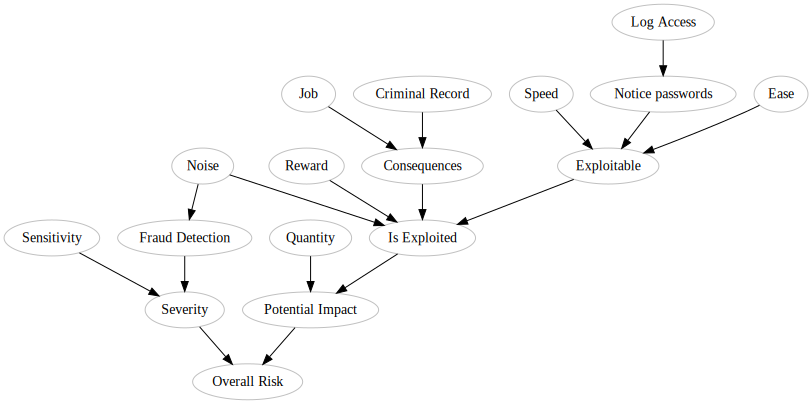

In [3]:
g = render_graph(structures, variables)

g

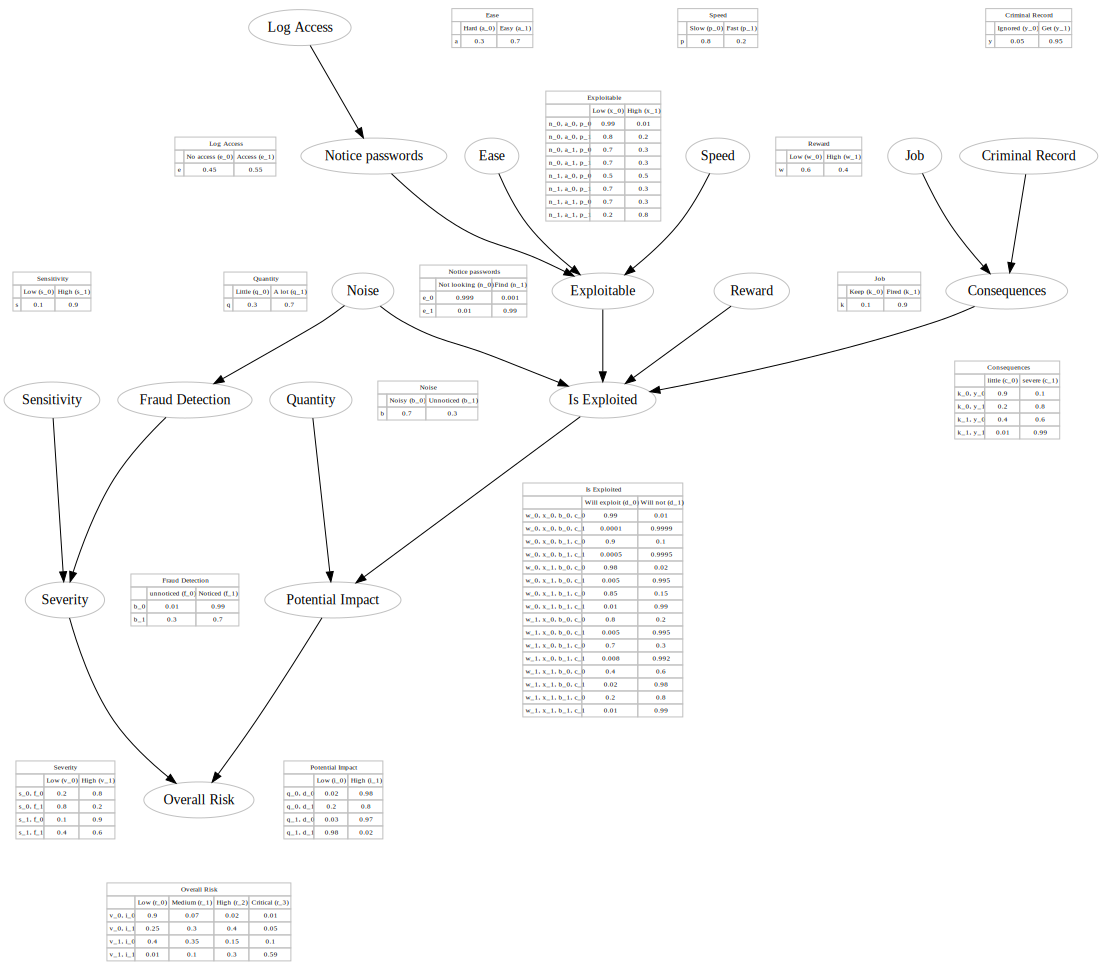

In [4]:
g = render_graph_probabilities(g, variables)

g

## Compiling our model with pgmpy

The following cell compiles the model and confirm that the probabilities are properly configured.

In [5]:
from graphviz_helper import build_BayesianModel

# Defining the model structure. We can define the network by just passing a list of edges.
model = build_BayesianModel(structures, variables)

model.check_model()

True

## Querying our model

Now that we have a configured model, we can start making up scenarios.

In [6]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)


### Question 1: Without any evidence, what are the likelihoods of a Low (0), Medium (1),  High (2) and Critical (3) risks?

In [7]:
print(infer.query(['R']) ['R'])
print(infer.map_query(['R']))

╒═════╤══════════╕
│ R   │   phi(R) │
╞═════╪══════════╡
│ R_0 │   0.4615 │
├─────┼──────────┤
│ R_1 │   0.2202 │
├─────┼──────────┤
│ R_2 │   0.1670 │
├─────┼──────────┤
│ R_3 │   0.1513 │
╘═════╧══════════╛
{'R': 0}


Without any evidence, as our model is defined, the most likely Overal Risk is Low with 46%

### Question 2: Knowing that the monitoring systems would have detected an abuse, how likely is it that severity would become high?

In [8]:
query_variable = ['V'] # Severity
evidence = {
    'S': 1, # Data leaked is sensitive
    'F': 1, # The monitoring system would have found it
}

for q in query_variable:
    if q not in evidence.keys():
        print((infer.query([q], evidence=evidence) [q]))
        print(infer.map_query(query_variable, evidence=evidence))
    else:
        print("{} is observed as {}".format(q,evidence[q]))

╒═════╤══════════╕
│ V   │   phi(V) │
╞═════╪══════════╡
│ V_0 │   0.4000 │
├─────┼──────────┤
│ V_1 │   0.6000 │
╘═════╧══════════╛
{'V': 1}


### Question 3: How exploitable is that data?

For this one, I am not sure that the model is correct, but here is the idea: 
First to be exploitable, someone must look for it (N). this depends on how many people have access to the data (E).
Then it depends how easy it is to exploit (A), and how fast (P) it can be done.

In [9]:
query_variable = ['X']
evidence = {
    'N': 1, # An empployee notice the data
    'A': 1, # It would be easy to exploit
    'P': 0, # But it would take some time to conduct the attack
}

for q in query_variable:
    if q not in evidence.keys():
        print((infer.query([q], evidence=evidence) [q]))
        print(infer.map_query(query_variable, evidence=evidence))
    else:
        print("{} is observed as {}".format(q,evidence[q]))

╒═════╤══════════╕
│ X   │   phi(X) │
╞═════╪══════════╡
│ X_0 │   0.7000 │
├─────┼──────────┤
│ X_1 │   0.3000 │
╘═════╧══════════╛
{'X': 0}


Even if the data is noticed, and it would be easy to exploit, only 30% would think about a way to exploit the data.

### Question 4: How would a potential attack estimate the consequences if he is given the chance to exploit the data?

In [10]:
query_variable = ['C'] # Consequences
evidence = {
    'K': 1, # Will lose their job if they are caught trying to use the data
    'Y': 1, # Will end up in court
}

for q in query_variable:
    if q not in evidence.keys():
        print((infer.query([q], evidence=evidence) [q]))
        print(infer.map_query(query_variable, evidence=evidence))
    else:
        print("{} is observed as {}".format(q,evidence[q]))

╒═════╤══════════╕
│ C   │   phi(C) │
╞═════╪══════════╡
│ C_0 │   0.0100 │
├─────┼──────────┤
│ C_1 │   0.9900 │
╘═════╧══════════╛
{'C': 1}


Knowing the potential consequences, it is most likely that an employee would not try to abuse the discovered password, with 99%. 

This likelihood might not be high enough. If we take the case of the NSA and Edward Snowden, even with all the accesses in the world and 35,000 to 55,000 employees, only 1 person used his privileges, that we know about. If it was only 1%, then we would have had 450 incidents caused by employees.

### Question 5: Given the exploitability and the consequences, how likely it is that an employee would try to exploit the data?

Let's say that the employee is not one of the sysadmin or is not part of the monitoring team, s/he probably can't tell if an attack would be noticed, so let's leave the Noise (B) variable unobserved.

Regarding the reward, here too let's assume that the employee is thinking about extracting the data before even knowing how the data could be used to gain a reward (W). Let's leave that variable unobserved as well

In [11]:
query_variable = ['D'] # Consequences
evidence = {
    'N': 1, # An empployee notice the data
    'A': 1, # It would be easy to exploit
    'P': 0, # But it would take some time to conduct the attack
    'K': 1, # Will lose their job if they are caught trying to use the data
    'Y': 1, # Will end up in court
}

for q in query_variable:
    if q not in evidence.keys():
        print((infer.query([q], evidence=evidence) [q]))
        print(infer.map_query(query_variable, evidence=evidence))
    else:
        print("{} is observed as {}".format(q,evidence[q]))

╒═════╤══════════╕
│ D   │   phi(D) │
╞═════╪══════════╡
│ D_0 │   0.0132 │
├─────┼──────────┤
│ D_1 │   0.9868 │
╘═════╧══════════╛
{'D': 1}


After considering the exploitability and the consequences, an employee would probably not try to exploit the data, with a probability if 98.68%.

## Final Question: 

### Given our hypothesis, what is the overall severity of the incident?

In [12]:
query_variable = ['V', 'I', 'R']
evidence = {
    'N': 1, # An empployee notice the data
    'A': 1, # It would be easy to exploit
    'P': 0, # But it would take some time to conduct the attack
    'K': 1, # Will lose their job if they are caught trying to use the data
    'Y': 1, # Will end up in court
    'S': 1, # Data leaked is sensitive
    'F': 1, # The monitoring system would have found it
}

for q in query_variable:
    if q not in evidence.keys():
        print((infer.query([q], evidence=evidence) [q]))
        print(infer.map_query(query_variable, evidence=evidence))
    else:
        print("{} is observed as {}".format(q,evidence[q]))

╒═════╤══════════╕
│ V   │   phi(V) │
╞═════╪══════════╡
│ V_0 │   0.4000 │
├─────┼──────────┤
│ V_1 │   0.6000 │
╘═════╧══════════╛
{'R': 0, 'V': 1, 'I': 0}
╒═════╤══════════╕
│ I   │   phi(I) │
╞═════╪══════════╡
│ I_0 │   0.7365 │
├─────┼──────────┤
│ I_1 │   0.2635 │
╘═════╧══════════╛
{'R': 0, 'V': 1, 'I': 0}
╒═════╤══════════╕
│ R   │   phi(R) │
╞═════╪══════════╡
│ R_0 │   0.4698 │
├─────┼──────────┤
│ R_1 │   0.2227 │
├─────┼──────────┤
│ R_2 │   0.1618 │
├─────┼──────────┤
│ R_3 │   0.1457 │
╘═════╧══════════╛
{'R': 0, 'V': 1, 'I': 0}


After configuring our hypothesis, the probability that this incident remains a Low risk incident slightly increased.

What would be a worst case scenario?

In [13]:
query_variable = ['V', 'I', 'R']
evidence = {
    'D': 0, # An employee decide to exploit the data
    'F': 0, # the attack goes unnoticed
    'Q': 1, # A huge quantity of data is exfiltrated
}

for q in query_variable:
    if q not in evidence.keys():
        print((infer.query([q], evidence=evidence) [q]))
        print(infer.map_query(query_variable, evidence=evidence))
    else:
        print("{} is observed as {}".format(q,evidence[q]))

╒═════╤══════════╕
│ V   │   phi(V) │
╞═════╪══════════╡
│ V_0 │   0.1100 │
├─────┼──────────┤
│ V_1 │   0.8900 │
╘═════╧══════════╛
{'R': 3, 'V': 1, 'I': 1}
╒═════╤══════════╕
│ I   │   phi(I) │
╞═════╪══════════╡
│ I_0 │   0.0300 │
├─────┼──────────┤
│ I_1 │   0.9700 │
╘═════╧══════════╛
{'R': 3, 'V': 1, 'I': 1}
╒═════╤══════════╕
│ R   │   phi(R) │
╞═════╪══════════╡
│ R_0 │   0.0490 │
├─────┼──────────┤
│ R_1 │   0.1279 │
├─────┼──────────┤
│ R_2 │   0.3057 │
├─────┼──────────┤
│ R_3 │   0.5174 │
╘═════╧══════════╛
{'R': 3, 'V': 1, 'I': 1}


The updated risk level of the incident changes dramatically: 30.57% probability that this incident becomes a High Overall Risk incident, and 51.75% that it becomes Critical.

At this point, the worst happened. Good luck